<a href="https://colab.research.google.com/github/soma00333/cuboulder-csca5622/blob/main/CSCA_5622_Supervised_Learning_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# ------------------------------
# Import CSV
# ------------------------------
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/CUBoulder/global-energy-forecasting-competition-2012-load-forecasting'

df_load = pd.read_csv(os.path.join(base_path, 'Load_history.csv'))
df_temp = pd.read_csv(os.path.join(base_path, 'temperature_history.csv'))
df_bench = pd.read_csv(os.path.join(base_path, 'Benchmark.csv'))

df_load.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,"16,853","16,450","16,517","16,873","17,064","17,727",...,"13,518","13,138","14,130","16,809","18,150","18,235","17,925","16,904","16,162","14,750"
1,1,2004,1,2,"14,155","14,038","14,019","14,489","14,920","16,072",...,"16,127","15,448","15,839","17,727","18,895","18,650","18,443","17,580","16,467","15,258"
2,1,2004,1,3,"14,439","14,272","14,109","14,081","14,775","15,491",...,"13,507","13,414","13,826","15,825","16,996","16,394","15,406","14,278","13,315","12,424"
3,1,2004,1,4,"11,273","10,415","9,943","9,859","9,881","10,248",...,"14,207","13,614","14,162","16,237","17,430","17,218","16,633","15,238","13,580","11,727"
4,1,2004,1,5,"10,750","10,321","10,107","10,065","10,419","12,101",...,"13,845","14,350","15,501","17,307","18,786","19,089","19,192","18,416","17,006","16,018"


Null counts after merging:
Date             0
Load             0
zone_id          0
Temperature    140
station_id     140
dtype: int64


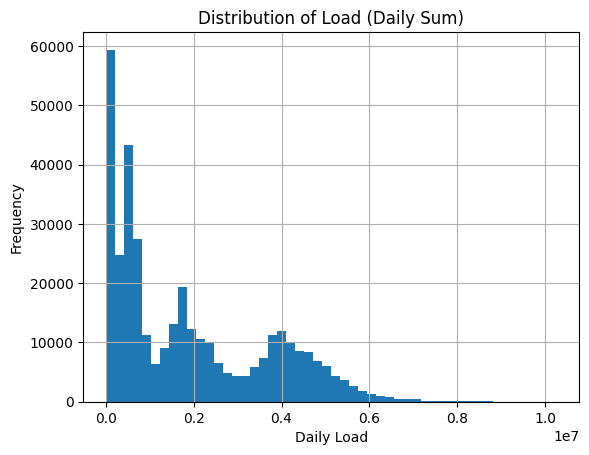

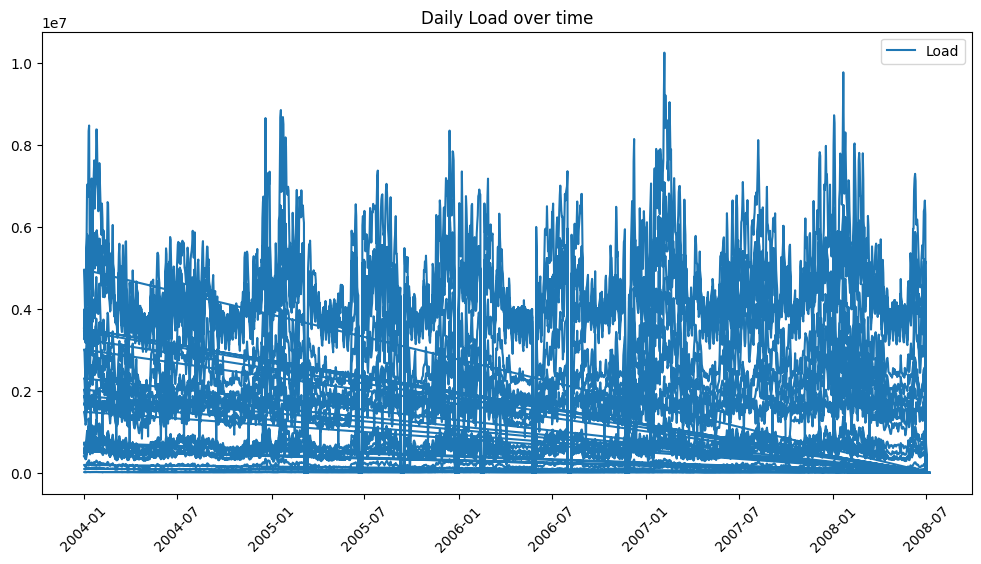

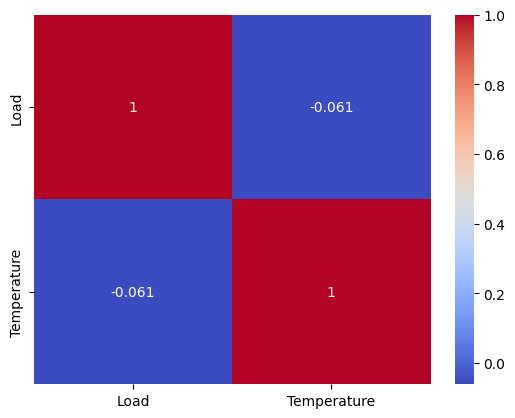

In [22]:
# ------------------------------
# EDA
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Remove comma separator → Convert to float
load_hour_cols = [f"h{i}" for i in range(1,25)]
for col in load_hour_cols:
    df_load[col] = pd.to_numeric(
        df_load[col].astype(str).str.replace(',', '', regex=False),
        errors='coerce'
    )

temp_hour_cols = [f"h{i}" for i in range(1,25)]

# Create a Datetime column
df_load['Date'] = pd.to_datetime(df_load[['year','month','day']])
df_temp['Date'] = pd.to_datetime(df_temp[['year','month','day']])

# Create "Total daily electricity demand" (Load)
df_load['Load'] = df_load[load_hour_cols].sum(axis=1)

# Create "Average Daily Temperature" (Temperature)
df_temp['Temperature'] = df_temp[temp_hour_cols].mean(axis=1)

# Keep only the necessary columns (if you use other keys such as zone_id, keep them as appropriate)
df_load_sub = df_load[['Date','Load','zone_id']]
df_temp_sub = df_temp[['Date','Temperature','station_id']]

# Merge
df_merged = pd.merge(
    df_load_sub,
    df_temp_sub,
    on='Date',
    how='left'
)
print("Null counts after merging:")
print(df_merged.isnull().sum())

# Load histogram
df_merged['Load'].hist(bins=50)
plt.title("Distribution of Load (Daily Sum)")
plt.xlabel("Daily Load")
plt.ylabel("Frequency")
plt.show()

# Time Series Plot
plt.figure(figsize=(12,6))
plt.plot(df_merged['Date'], df_merged['Load'], label='Load')
plt.xticks(rotation=45)
plt.title("Daily Load over time")
plt.legend()
plt.show()

# Correlation with Temperature
corr = df_merged[['Load','Temperature']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

<ipython-input-23-76d946c5b1ca>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Temperature'].fillna(df_merged['Temperature'].mean(), inplace=True)


RMSE on Test Data: 1806025.313823137


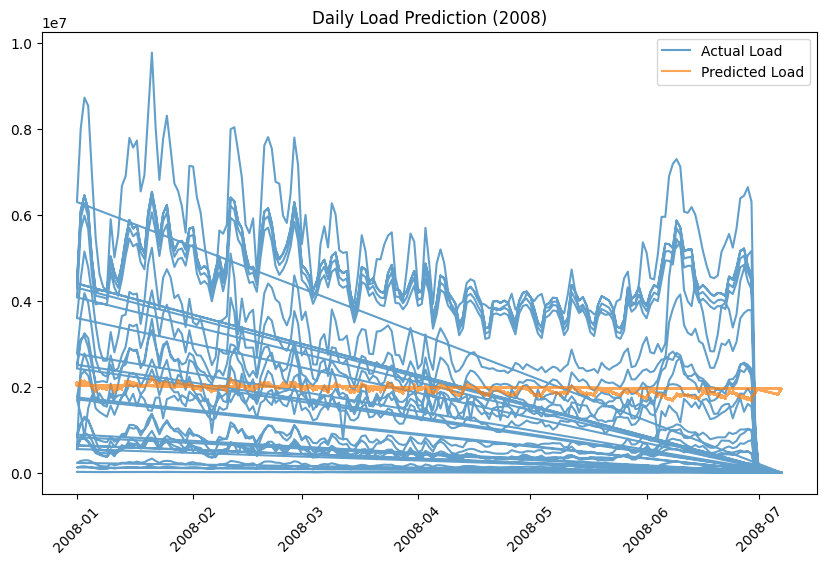

In [23]:
# ------------------------------
# Building a regression model
# ------------------------------
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Filling in the gaps
df_merged['Temperature'].fillna(df_merged['Temperature'].mean(), inplace=True)

# Create a new feature
df_merged['month'] = df_merged['Date'].dt.month
df_merged['day_of_week'] = df_merged['Date'].dt.weekday
df_merged['year'] = df_merged['Date'].dt.year

# Split into training data and test data (2008 is the test data)
train_data = df_merged[df_merged['year'] < 2008].copy()
test_data  = df_merged[df_merged['year'] == 2008].copy()

feature_cols = ['Temperature','month','day_of_week']
X_train = train_data[feature_cols]
y_train = train_data['Load']

X_test = test_data[feature_cols]
y_test = test_data['Load']

# If any gaps remain, delete the row.
train_data.dropna(subset=feature_cols + ['Load'], inplace=True)
test_data.dropna(subset=feature_cols + ['Load'], inplace=True)

# Take X and y again
X_train = train_data[feature_cols]
y_train = train_data['Load']

X_test = test_data[feature_cols]
y_test = test_data['Load']

# Training a Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

# Evaluation (RMSE)
rmse_linear = math.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on Test Data:", rmse_linear)

# Visualization of prediction results
plt.figure(figsize=(10,6))
plt.plot(test_data['Date'], y_test, label='Actual Load', alpha=0.7)
plt.plot(test_data['Date'], y_pred, label='Predicted Load', alpha=0.7)
plt.xticks(rotation=45)
plt.title("Daily Load Prediction (2008)")
plt.legend()
plt.show()


RandomForest RMSE: 1813971.500093187


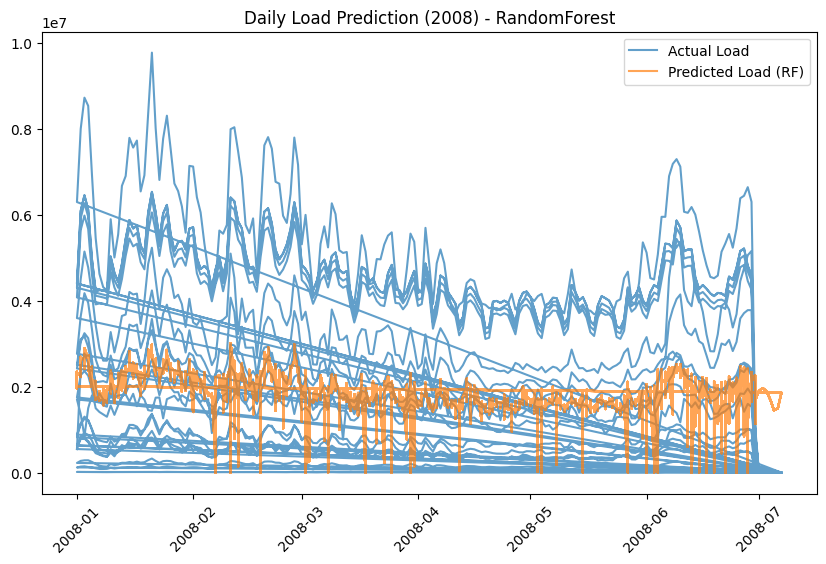

In [24]:
# ------------------------------
# Building a random forest model
# ------------------------------
from sklearn.ensemble import RandomForestRegressor

# 1) Create a random forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# study
model_rf.fit(X_train, y_train)

# prediction
y_pred_rf = model_rf.predict(X_test)

# Evaluation (RMSE)
rmse_rf = math.sqrt(mean_squared_error(y_test, y_pred_rf))
print("RandomForest RMSE:", rmse_rf)

# Visualization: Actual vs. predicted
plt.figure(figsize=(10,6))
plt.plot(test_data['Date'], y_test, label='Actual Load', alpha=0.7)
plt.plot(test_data['Date'], y_pred_rf, label='Predicted Load (RF)', alpha=0.7)
plt.xticks(rotation=45)
plt.title("Daily Load Prediction (2008) - RandomForest")
plt.legend()
plt.show()


LinearRegression RMSE: 1806025.313823137
RandomForest   RMSE: 1813971.500093187
Temperature: 0.732
month: 0.106
day_of_week: 0.162


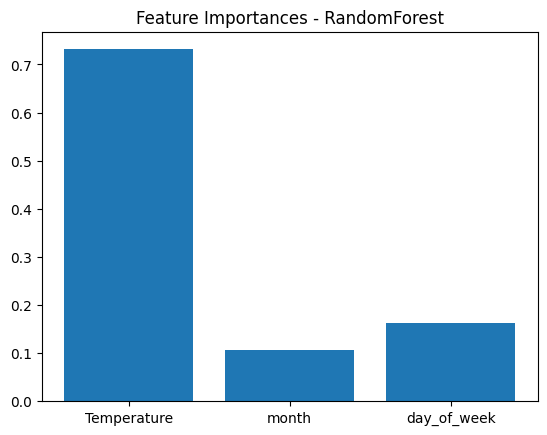

In [25]:
# ------------------------------
# Evaluate 2 models
# ------------------------------
print("LinearRegression RMSE:", rmse_linear)
print("RandomForest   RMSE:", rmse_rf)

importance = model_rf.feature_importances_
for col, imp in zip(feature_cols, importance):
    print(f"{col}: {imp:.3f}")

plt.bar(feature_cols, importance)
plt.title("Feature Importances - RandomForest")
plt.show()